# Review Predictions from Firebase

This notebook allows you to connect to Firestore and review the predictions generated by your pipeline.

In [1]:
import os
import pandas as pd
from google.cloud import firestore
import matplotlib.pyplot as plt
from datetime import datetime

# Try to get PROJECT_ID from environment, otherwise set it manually
# You can find your project ID in the Google Cloud Console
PROJECT_ID = os.getenv('PROJECT_ID') 
COLLECTION_NAME = 'predictions'

print(f"Project ID: {PROJECT_ID}")

Project ID: time-series-478616


In [13]:
def get_firestore_client(project_id):
    return firestore.Client(project=project_id)

def fetch_predictions(db, collection, limit=None):
    query = db.collection(collection).order_by('timestamp', direction=firestore.Query.DESCENDING)
    
    if limit:
        print(f"Fetching last {limit} documents from '{collection}'...")
        query = query.limit(limit)
    else:
        print(f"Fetching ALL documents from '{collection}'...")
        
    docs_stream = query.stream()
    
    data = []
    for doc in docs_stream:
        d = doc.to_dict()
        row = {
            'doc_id': doc.id,
            'time': d.get('timestamp_str'),
            'route': d.get('route_id'),
            'stop': d.get('stop_id'),
            'pred_mbt': d.get('predicted_mbt'),
            'status': d.get('status'),
            'created': d.get('created_at')
        }
        data.append(row)
    return pd.DataFrame(data)

In [14]:
if PROJECT_ID == 'your-project-id-here':
    print("⚠️ Please set your PROJECT_ID in the first cell.")
else:
    try:
        db = get_firestore_client(PROJECT_ID)
        # Fetch all records by setting limit to None
        df = fetch_predictions(db, COLLECTION_NAME, limit=None)
        
        if not df.empty:
            print(f"✅ Retrieved {len(df)} records.")
            display(df.head())
            
            # Basic stats
            print("\nStatistics:")
            print(df['pred_mbt'].describe())
        else:
            print("❌ No data found.")
    except Exception as e:
        print(f"Error connecting to Firestore: {e}")
        print("Make sure you are authenticated with 'gcloud auth application-default login'")

Fetching ALL documents from 'predictions'...
✅ Retrieved 282 records.


,doc_id,time,route,stop,pred_mbt,status,created
0,E_F11S_1766588572,2025-12-24T15:02:52,E,F11S,3.488432,WARMUP (159/160),2025-12-24 15:03:24.113000+00:00
1,E_F11S_1766588552,2025-12-24T15:02:32,E,F11S,2.722983,WARMUP (159/160),2025-12-24 15:02:53.881000+00:00
2,E_F11S_1766588517,2025-12-24T15:01:57,E,F11S,1.994564,WARMUP (159/160),2025-12-24 15:02:24.969000+00:00
3,E_F11S_1766587947,2025-12-24T14:52:27,E,F11S,2.134874,WARMUP (159/160),2025-12-24 14:52:53.965000+00:00
4,E_F11S_1766587917,2025-12-24T14:51:57,E,F11S,2.678079,WARMUP (159/160),2025-12-24 14:52:24.239000+00:00



Statistics:
count    282.000000
mean       1.860276
std        2.229746
min       -3.237768
25%        0.270429
50%        1.686447
75%        3.013740
max        8.696621
Name: pred_mbt, dtype: float64


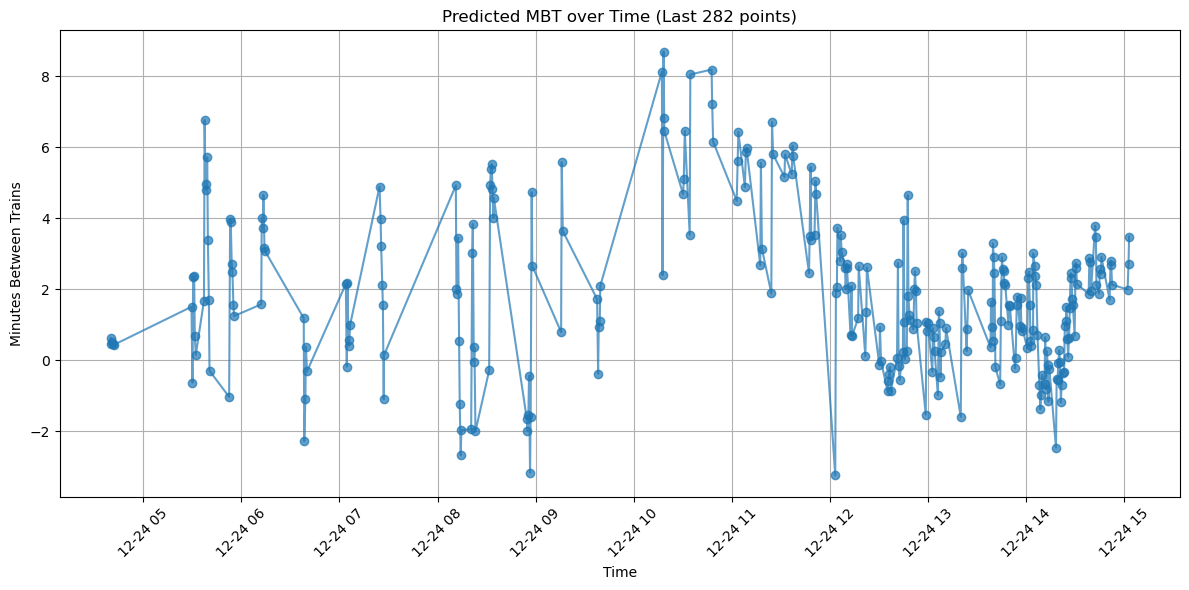

In [15]:
if 'df' in locals() and not df.empty:
    # Convert time to datetime for plotting
    # Handle potential parsing errors or different formats if necessary
    try:
        df['time'] = pd.to_datetime(df['time'])
        df = df.sort_values('time')

        plt.figure(figsize=(12, 6))
        plt.plot(df['time'], df['pred_mbt'], marker='o', linestyle='-', alpha=0.7)
        plt.title(f"Predicted MBT over Time (Last {len(df)} points)")
        plt.xlabel("Time")
        plt.ylabel("Minutes Between Trains")
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not plot data: {e}")

In [6]:
# Count total documents in the collection
if 'db' in locals():
    try:
        collection_ref = db.collection(COLLECTION_NAME)
        # Aggregation query
        count_query = collection_ref.count()
        results = count_query.get()
        
        # results[0] is the aggregation result, [0] is the first alias (default is count)
        total_count = results[0][0].value
        
        print(f"Total documents in '{COLLECTION_NAME}': {total_count}")
    except Exception as e:
        print(f"Error counting documents: {e}")
else:
    print("Database client 'db' not initialized. Run the setup cells first.")

Total documents in 'predictions': 279


In [31]:
df[150:160]

,doc_id,time,route,stop,pred_mbt,status,created
131,E_F11S_1766579832,2025-12-24 12:37:12,E,F11S,-0.860444,WARMUP (154/160),2025-12-24 12:37:24.334000+00:00
130,E_F11S_1766580057,2025-12-24 12:40:57,E,F11S,0.063370,WARMUP (155/160),2025-12-24 12:41:25.029000+00:00
129,E_F11S_1766580092,2025-12-24 12:41:32,E,F11S,2.742082,WARMUP (156/160),2025-12-24 12:41:54.018000+00:00
128,E_F11S_1766580117,2025-12-24 12:41:57,E,F11S,-0.147317,WARMUP (157/160),2025-12-24 12:42:24.934000+00:00
127,E_F11S_1766580152,2025-12-24 12:42:32,E,F11S,-0.553742,WARMUP (158/160),2025-12-24 12:42:54.453000+00:00
126,E_F11S_1766580274,2025-12-24 12:44:34,E,F11S,0.229963,WARMUP (159/160),2025-12-24 12:44:54.716000+00:00
125,E_F11S_1766580297,2025-12-24 12:44:57,E,F11S,3.945288,WARMUP (159/160),2025-12-24 12:45:24.853000+00:00
124,E_F11S_1766580332,2025-12-24 12:45:32,E,F11S,1.093004,WARMUP (159/160),2025-12-24 12:45:53.832000+00:00
123,E_F11S_1766580342,2025-12-24 12:45:42,E,F11S,0.033180,WARMUP (159/160),2025-12-24 12:46:24.345000+00:00
122,E_F11S_1766580417,2025-12-24 12:46:57,E,F11S,0.265352,WARMUP (159/160),2025-12-24 12:47:24.484000+00:00
